# Figure 5: Mean and Deviation plot
Anna Mackie, 2022

See section 4.1 of paper. Here, we compare the proportion of variability across the RCEMIP models' dynamic components due to variations in R, and that due to variations in dA. We do this by calculating the mean (overline) of R and dA. We use these, and the individual model R and dA values, to calculate the dynamic component, and scatter these against the 'real' dynamic components. i.e. we calculate the integral, over vertical velocity of \overline{R}dA and R\overline{dA}, and plot against the dynamic component


In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from scipy import stats
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import sys
sys.path.append('..')
import funcs

In [3]:
# constants
arrs = ['lwcrf', 'swcrf']
arrT = ['LW CRE', 'SW CRE']
pLev = 500
alpha = 0.8
comps = ['total', 'dynamic',  'thermodynamic', 'non-linear', 'dyn/tot']
deltaT = 5
p_cut_off = 0.01 # statistical significance test
ms = 8 # marker size

In [2]:
models = ['CM1',  'dam','ICON_LEM_CRM', 'ICON_NWP_CRM', 'MESONH', 'SAM_CRM', 'SCALE', 'UCLA-CRM',
          'UKMOi-vn11.0-CASIM', 'UKMOi-vn11.0-RA1-T', 'UKMOi-vn11.0-RA1-T-nocloud', 'WRF_COL_CRM']
m = len(models)
cols =  np.load('color_grid.npy', allow_pickle = True)

# limits of vertical velocity, common across models
pl = 0.22 # pos limit
nlim= -0.07 # neg limit
bs = 0.001 # bin size

bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of vertical velocity bins: ', b)
mnbin = [] # create array of the mid-point between bin limits for plotting
for i in range(1,b):
    mnbin = np.append(mnbin, np.mean([bins[i-1], bins[i]])*100)


no of vertical velocity bins:  291


/home/users/arm33/RCEMIP/allMod/../funcs.py:120: RuntimeWarning: Mean of empty slice
  arrbin = [np.nanmean(arr[dig==i]) for i in range(1,b)]
/tmp/ipykernel_4472/495591355.py:86: RuntimeWarning: Mean of empty slice
  Rmn = np.nanmean(Rmn[1:,], axis = 0)


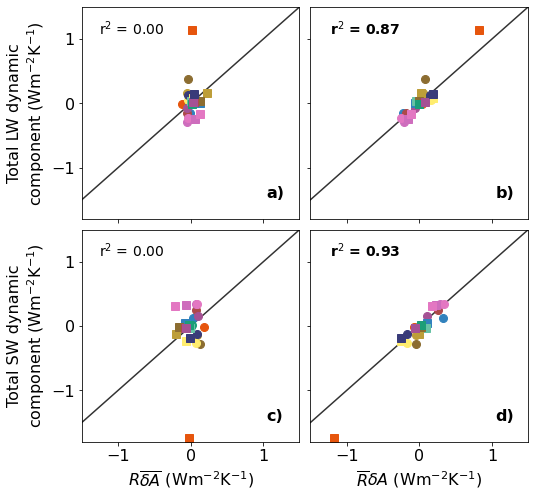

In [8]:
"""
This code loops over LW/SW and lower/higher temp change.

It then loops over the models to create the mean dA and R arrays, and compute the 'adjusted' and the 'real' dynamic
effect.

These are then scattered against each other
"""

# make R mean and R'
ylim = [-1.8,1.5]
xlim = [-1.5,1.5]#[-0.2, 0.2]

lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']

#lwcrf, lower temps
fig3, axes3 = plt.subplots(2,2)
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16
for i in [0,1]:
    for j in [0,1]:
        ax = axes3[i,j]
        #ax.plot([xlim1[0], xlim1[1]], [ylim[0], ylim[1]], 'k-', alpha = 0.8)
        ax.plot([-1.5, 1.5], [-1.5, 1.5], 'k-', alpha = 0.8)

l = 1
c=0

############# CRMs ###################
anoms = 0 # leave in MESONH and UCLA, 305-300K
t2S, t3S, dynS = np.empty((2,2*m-anoms)),np.empty((2,2*m-anoms)),np.empty((2,2*m-anoms))   # empty arrays for dynamic components   

for i in [0,1]: # loop over SW and LW
    arr = arrs[i]
    counter = 0
    
    for j in [0,1]: # loop over lower or higher temperature change
        Rmn = np.empty((1,b-1))  #empty arrays to create the mean across models
        dAmn = np.empty((1,b-1))
           
        if j==0:
            con,new = '295', '300'
            marker = 'o'

        if j==1:
            con,new = '300', '305'
            marker = 's'
                    
        # make mean R and dA
        for k in range(m):
            model = models[k]
            
            dp3 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/large'
            dp2 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/large'
            #calc the wa500 on the 'wonky' level at the control temp
            wa = np.load(dp3 + con + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + con + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa5001 = funcs.getPlevel(wa, pa, pLev)

            # and the new temp
            wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa5002 = funcs.getPlevel(wa, pa, pLev)

            #calc dynamic effect with 3D data
            crf1 = np.load(dp2 + con + arr +'24hrs.npy', allow_pickle = True)
            crf2 = np.load(dp2 + new + arr +'24hrs.npy', allow_pickle = True)

            #control functions
            dig1 = np.digitize(wa5001, bins)
            A1 = funcs.createA(dig1, b)
            R1 = funcs.createR(crf1, dig1, b)
            R1 = funcs.rpTrailingZeros(A1,R1)
            #new functions
            dig2 = np.digitize(wa5002, bins)
            A2 = funcs.createA(dig2, b)
            R2 = funcs.createR(crf2, dig2, b)
            R2 = funcs.rpTrailingZeros(A2,R2)

            dA = A2 - A1

            dAmn = np.vstack((dAmn, dA)) # these arrays contain the dA and R functions for all models
            Rmn = np.vstack((Rmn, R1))

        # calculate the mean        
        Rmn = np.nanmean(Rmn[1:,], axis = 0)
        dAmn = np.nanmean(dAmn[1:,], axis = 0)
        
        #calculate the dynamic effects arising from using mean values, and the 'real' dynamic effect
        for k in range(m):
            model = models[k]
           
            dp3 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/large'
            dp2 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/large'

            # the lower temperature vertical velocity field
            wa = np.load(dp3 + con + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + con + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa5001 = funcs.getPlevel(wa, pa, pLev)

            # and the new temperature vertical velocity field
            wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa5002 = funcs.getPlevel(wa, pa, pLev)

            # calc dynamic component

            #load data
            crf1 = np.load(dp2 + con + arr +'24hrs.npy', allow_pickle = True)
            crf2 = np.load(dp2 + new + arr +'24hrs.npy', allow_pickle = True)

            # lower temperature functions
            dig1 = np.digitize(wa5001, bins)
            A1 = funcs.createA(dig1, b)
            R1 = funcs.createR(crf1, dig1, b)
            R1 = funcs.rpTrailingZeros(A1,R1)
            # higher temperature functions
            dig2 = np.digitize(wa5002, bins)
            A2 = funcs.createA(dig2, b)

            dA = A2 - A1

            t2 = np.nansum(R1*dAmn/deltaT) #  dyn component using mean dA
            t3 = np.nansum(Rmn*dA/deltaT) # dyn component using mean R

            tot, th, dyn, nl = funcs.decompose(A1,A2, R1, R2, deltaT) # calculate real dynamic component 

            t2S[i,counter] = t2
            t3S[i,counter] = t3
            dynS[i,counter] = dyn

            # top row - R mean(dA); bottom row - mean(R); dA
            axes3[i,0].plot(t2, dyn, marker = marker, color = cols[k], markersize = ms)
            axes3[i,1].plot(t3, dyn, marker = marker, color = cols[k], markersize = ms)
            counter +=1    

                
    # add in correlation coefficients, bold if pass significance test            
    s, icpt, r, p, stderr = stats.linregress(t2S[i,:], dynS[i,:])
    txtstr = 'r$^2$ = ' + "{:.2f}".format(r**2)
    if p < p_cut_off:
        axes3[i,0].text(0.23, 0.9, txtstr, horizontalalignment='center',
                        verticalalignment='center',transform=axes3[i,0].transAxes, weight = 'bold', fontsize = 14) 
    else:
        axes3[i,0].text(0.23, 0.9, txtstr, horizontalalignment='center',
                    verticalalignment='center',transform=axes3[i,0].transAxes, fontsize = 14)
    axes3[0,i].text(0.85, 0.1, lets[c], fontweight ='bold' ,transform=axes3[0,i].transAxes)

    s, icpt, r, p, stderr = stats.linregress(t3S[i,:], dynS[i,:])
    txtstr = 'r$^2$ = ' + "{:.2f}".format(r**2)
    if p < p_cut_off:
        axes3[i,1].text(0.25, 0.9, txtstr, horizontalalignment='center',
                        verticalalignment='center', transform=axes3[i,1].transAxes, weight = 'bold', fontsize = 14)
    else:
        axes3[i,1].text(0.25, 0.9, txtstr, horizontalalignment='center',
                    verticalalignment='center', transform=axes3[i,1].transAxes, fontsize = 14)

    axes3[1,i].text(0.85, 0.1, lets[c+2], fontweight = 'bold',transform=axes3[1,i].transAxes)

    c+=1

        
fig3.set_size_inches(8,8) 

axes3[1, 0].set_xlabel('$R\overline{\delta A}$ (Wm$^{-2}$K$^{-1}$)')
axes3[1, 1].set_xlabel('$\overline{R}\delta A$ (Wm$^{-2}$K$^{-1}$)')

plt.setp(axes3[0,0], ylabel = 'Total LW dynamic\ncomponent (Wm$^{-2}$K$^{-1}$)')
plt.setp(axes3[1,0], ylabel = 'Total SW dynamic\ncomponent (Wm$^{-2}$K$^{-1}$)')

plt.setp(axes3[:,1], yticklabels = '')

plt.setp(axes3, xlim = xlim, ylim = ylim)

plt.setp(axes3[1,:], xticks = [-1, 0, 1])
plt.setp(axes3[0,:], xticks = [-1, 0, 1], xticklabels = '')

plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
fig3.savefig('revised_plots/Fig5.pdf', bbox_inches = 'tight')

## Repeat with outliers taken out - not used

Taking MESONH and UCLA 305-300K out.


/home/users/arm33/RCEMIP/allMod/../funcs.py:128: RuntimeWarning: Mean of empty slice
  arrbin = [np.nanmean(arr[dig==i]) for i in range(1,b)]
/tmp/ipykernel_6145/2547216769.py:90: RuntimeWarning: Mean of empty slice
  Rmn = np.nanmean(Rmn[1:,], axis = 0)


removing MESONH 305-300
removing UCLA-CRM 305-300
removing MESONH 305-300
removing UCLA-CRM 305-300
removing MESONH 305-300
removing UCLA-CRM 305-300
removing MESONH 305-300
removing UCLA-CRM 305-300


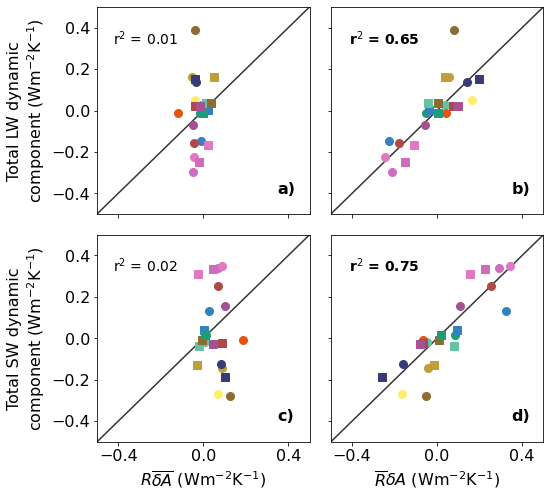

In [5]:
"""
This code loops over LW/SW and lower/higher temp change.

There are then two loops over the models, the first is to create the mean dA and R arrays, 
the second is to compute the prime values (each model - mean across models) and the 'real' dynamic
effect.

These are then scattered against each other
"""

# make R mean and R'
ylim = [-0.5,0.5]
xlim1 = [-0.5,0.5]#[-0.2, 0.2]
xlim2 = [-0.5,0.5]#[-0.4, 0.4]
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']

#lwcrf, lower temps
fig3, axes3 = plt.subplots(2,2)
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16
for i in [0,1]:
    for j in [0,1]:
        ax = axes3[i,j]
        ax.plot([xlim1[0], xlim1[1]], [ylim[0], ylim[1]], 'k-', alpha = 0.8)

l = 1
c=0

############# CRMs ###################
anoms = 2 # two anomalies: MESONH and UCLA, 305-300K
t2S, t3S, dynS = np.empty((2,2*m-anoms)),np.empty((2,2*m-anoms)),np.empty((2,2*m-anoms))   # empty arrays for dynamic components   

for i in [0,1]: # loop over SW and LW
    arr = arrs[i]
    counter = 0
    
    for j in [0,1]: # loop over lower or higher temperature change
        Rmn = np.empty((1,b-1))  #empty arrays to create the mean across models
        dAmn = np.empty((1,b-1))
           
        if j==0:
            con,new = '295', '300'
            marker = 'o'

        if j==1:
            con,new = '300', '305'
            marker = 's'
                    
        # make mean R and dA
        for k in range(m):
            model = models[k]
            if j==1 and model == 'UCLA-CRM':
                print('removing UCLA-CRM 305-300')
            elif j==1 and model == 'MESONH':
                print('removing MESONH 305-300')
            else:
                dp3 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/large'
                dp2 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/large'
                #calc the wa500 on the 'wonky' level at the control temp
                wa = np.load(dp3 + con + 'wa_profile_25d.npy', allow_pickle = True)
                pa = np.load(dp3 + con + 'pa_profile_25d.npy', allow_pickle = True)/100
                wa5001 = funcs.getPlevel(wa, pa, pLev)

                # and the new temp
                wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
                pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
                wa5002 = funcs.getPlevel(wa, pa, pLev)

                #calc dynamic effect with 3D data
                crf1 = np.load(dp2 + con + arr +'24hrs.npy', allow_pickle = True)
                crf2 = np.load(dp2 + new + arr +'24hrs.npy', allow_pickle = True)

                #control functions
                dig1 = np.digitize(wa5001, bins)
                A1 = funcs.createA(dig1, b)
                R1 = funcs.createR(crf1, dig1, b)
                R1 = funcs.rpTrailingZeros(A1,R1)
                #new functions
                dig2 = np.digitize(wa5002, bins)
                A2 = funcs.createA(dig2, b)
                R2 = funcs.createR(crf2, dig2, b)
                R2 = funcs.rpTrailingZeros(A2,R2)

                dA = A2 - A1

                dAmn = np.vstack((dAmn, dA)) # these arrays contain the dA and R functions for all models
                Rmn = np.vstack((Rmn, R1))

        # calculate the mean        
        Rmn = np.nanmean(Rmn[1:,], axis = 0)
        dAmn = np.nanmean(dAmn[1:,], axis = 0)
        
        #calculate the dynamic effects arising from using mean values, and the 'real' dynamic effect
        for k in range(m):
            model = models[k]
            if j==1 and model == 'UCLA-CRM':
                print('removing UCLA-CRM 305-300')
            elif j==1 and model == 'MESONH':
                print('removing MESONH 305-300')
            else:
                dp3 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/large'
                dp2 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/large'
                
                # the lower temperature vertical velocity field
                wa = np.load(dp3 + con + 'wa_profile_25d.npy', allow_pickle = True)
                pa = np.load(dp3 + con + 'pa_profile_25d.npy', allow_pickle = True)/100
                wa5001 = funcs.getPlevel(wa, pa, pLev)

                # and the new temperature vertical velocity field
                wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
                pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
                wa5002 = funcs.getPlevel(wa, pa, pLev)

                # calc dynamic component
                
                #load data
                crf1 = np.load(dp2 + con + arr +'24hrs.npy', allow_pickle = True)
                crf2 = np.load(dp2 + new + arr +'24hrs.npy', allow_pickle = True)

                # lower temperature functions
                dig1 = np.digitize(wa5001, bins)
                A1 = funcs.createA(dig1, b)
                R1 = funcs.createR(crf1, dig1, b)
                R1 = funcs.rpTrailingZeros(A1,R1)
                # higher temperature functions
                dig2 = np.digitize(wa5002, bins)
                A2 = funcs.createA(dig2, b)

                dA = A2 - A1

                t2 = np.nansum(R1*dAmn/deltaT) #  dyn component using mean dA
                t3 = np.nansum(Rmn*dA/deltaT) # dyn component using mean R
                
                tot, th, dyn, nl = funcs.decompose(A1,A2, R1, R2, deltaT) # calculate real dynamic component 

                t2S[i,counter] = t2
                t3S[i,counter] = t3
                dynS[i,counter] = dyn

                # top row - R mean(dA); bottom row - mean(R); dA
                axes3[i,0].plot(t2, dyn, marker = marker, color = cols[k], markersize = ms)
                axes3[i,1].plot(t3, dyn, marker = marker, color = cols[k], markersize = ms)
                counter +=1    

                
    # add in correlation coefficients, bold if pass significance test            
    s, icpt, r, p, stderr = stats.linregress(t2S[i,:], dynS[i,:])
    txtstr = 'r$^2$ = ' + "{:.2f}".format(r**2)
    if p < p_cut_off:
        axes3[i,0].text(0.23, 0.85, txtstr, horizontalalignment='center',
                        verticalalignment='center',transform=axes3[i,0].transAxes, weight = 'bold', fontsize = 14) 
    else:
        axes3[i,0].text(0.23, 0.85, txtstr, horizontalalignment='center',
                    verticalalignment='center',transform=axes3[i,0].transAxes, fontsize = 14)
    axes3[0,i].text(0.85, 0.1, lets[c], fontweight ='bold' ,transform=axes3[0,i].transAxes)

    s, icpt, r, p, stderr = stats.linregress(t3S[i,:], dynS[i,:])
    txtstr = 'r$^2$ = ' + "{:.2f}".format(r**2)
    if p < p_cut_off:
        axes3[i,1].text(0.25, 0.85, txtstr, horizontalalignment='center',
                        verticalalignment='center', transform=axes3[i,1].transAxes, weight = 'bold', fontsize = 14)
    else:
        axes3[i,1].text(0.25, 0.85, txtstr, horizontalalignment='center',
                    verticalalignment='center', transform=axes3[i,1].transAxes, fontsize = 14)

    axes3[1,i].text(0.85, 0.1, lets[c+2], fontweight = 'bold',transform=axes3[1,i].transAxes)

    c+=1

        
fig3.set_size_inches(8,8) 

axes3[1, 0].set_xlabel('$R\overline{\delta A}$ (Wm$^{-2}$K$^{-1}$)')
axes3[1, 1].set_xlabel('$\overline{R}\delta A$ (Wm$^{-2}$K$^{-1}$)')

plt.setp(axes3[0,0], ylabel = 'Total LW dynamic\ncomponent (Wm$^{-2}$K$^{-1}$)')
plt.setp(axes3[1,0], ylabel = 'Total SW dynamic\ncomponent (Wm$^{-2}$K$^{-1}$)')

plt.setp(axes3[:,1], yticklabels = '')
plt.setp(axes3[0, :], xlim = xlim1, ylim= ylim)
plt.setp(axes3[1, :], xlim = xlim2, ylim= ylim)
plt.setp(axes3[1,:], xticks = [-0.4, 0, 0.4])
plt.setp(axes3[0,:], xticks = [-0.4, 0, 0.4], xticklabels = '')

plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
#fig3.savefig('paperplots/Fig5.pdf', bbox_inches = 'tight')